## Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import einops


In [2]:
import sys
sys.path.append("..")
from affine import ChannelwiseAffineTransform2d

## ChannelwiseAffineTransform2d

Quick demo of the stand-alone affine layer 
and how it affects the inputs in the initial random initialization

In [3]:
aff = ChannelwiseAffineTransform2d(num_channels=1)
aff

ChannelwiseAffineTransform2d(
  (grid): Sequential(
    (0): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Mish()
    (2): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
)

/home/mikko/miniconda3/envs/affine/lib/python3.10/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


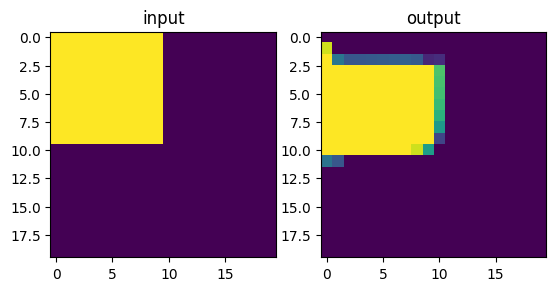

In [4]:
x_in = torch.zeros(1, 1, 20, 20)
x_in[..., :10, :10] = 1.

with torch.inference_mode():
    x_out = aff(x_in)
    
plt.subplot(121)
plt.imshow(x_in.sum(1)[0].cpu())
plt.title("input")
plt.subplot(122)
plt.imshow(x_out.sum(1)[0].cpu())
plt.title("output")
plt.show()

## Using as part of a model

This section demonstrates how to use the affine layer as part of a model.

More specifically, we showcase the capacity of the layer in a task, 
where the model has to move a square its face length to right and down in an image.
We also compare the performance to "Conv2dsOnly" model, which has all the equal parameters - plus some more.

The models are very shallow, so it is clear, that the "Conv2dsOnly" cannot perform well: 
the 3x Conv2d layers with kernel sizes (3,3) are simply not enough to solve the task. 

### Define a simple model

In [5]:
# we copy the Conv2ds from ChannelwiseAffineTransform2d
class Conv2dsOnly(ChannelwiseAffineTransform2d):
    def __init__(
            self,
            num_channels,
    ):
        super().__init__(num_channels=num_channels)
        self.out = nn.Conv2d(
                num_channels * 2,
                num_channels,
                kernel_size=3,
                padding="same"
            )
        
    def forward(self, x):
        b, c, h, w = x.size()
        pos = self.create_pos_encoding(x)
        grid = self.grid(torch.cat([x, pos], 1))
        out = self.out(grid)
        return out

In [6]:
class SimpleModel(nn.Module):
    def __init__(
            self,
            in_channels = 1,
            hidden_channels = 32,
            affine = True
    ):
        super().__init__()
        self.affine = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 1),
            ChannelwiseAffineTransform2d(hidden_channels) if affine else Conv2dsOnly(hidden_channels),
            nn.Conv2d(hidden_channels, in_channels, 1),
        )
        
    def forward(self, x):
        x = self.affine(x)
        x = torch.sigmoid(x)
        return x

### Define dataset

The dataset creates a background image of size 20x20 with all-zeroed pixels
and adds a random-sized square with all-ones to the top-left corner: this is the model's input.

The target is an image, where the square is moved 1x its face length to the right and down.

In [7]:
from torch.utils.data import Dataset, DataLoader
import random

class SquareShiftDataset(Dataset):
    def __init__(self, size=20, length=10000):
        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x_in = torch.zeros(1, self.size, self.size)
        x_out = torch.zeros_like(x_in)
        square_size = random.randint(2, self.size // 4)
        x0, y0 = torch.randint(0, self.size-square_size * 2, (2, ))
        x_in[..., y0:y0+square_size, x0:x0+square_size] = 1.
        x_out[..., y0+square_size: y0+square_size*2:, x0+square_size: x0+square_size*2] = 1.

        return x_in, x_out

### Train

In [8]:
# Initialize dataset and dataloader
dataset = SquareShiftDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
# Initialize model
model = SimpleModel()
no_aff_model = SimpleModel(affine=False)
if torch.cuda.is_available():
    model.cuda()
    no_aff_model.cuda()

In [10]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
no_aff_optimizer = optim.Adam(no_aff_model.parameters(), lr=1e-3)

In [11]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    no_aff_model.train()
    running_loss = 0.0
    no_aff_running_loss = 0.0
    steps = 0.
    with tqdm(dataloader, unit="batch") as tepoch:
        for inputs, targets in tepoch:
            steps += 1.
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")

            if torch.cuda.is_available():
                inputs, targets = inputs.cuda(), targets.cuda()

            # train the affine model
            optimizer.zero_grad()
            no_aff_optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            # train the no-affine model
            no_aff_outputs = no_aff_model(inputs)
            no_aff_loss = criterion(no_aff_outputs, targets)
            no_aff_loss.backward()
            no_aff_optimizer.step()
            # update the progress bar
            running_loss += loss.item()
            no_aff_running_loss += no_aff_loss.item()
            tepoch.set_postfix(loss=running_loss/steps, no_aff_loss=no_aff_running_loss/steps)

print('Finished Training')

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Finished Training


### Test

In [12]:
test_dataset = SquareShiftDataset(length=5)  # Generate 5 test examples
_ = model.eval(), no_aff_model.eval()

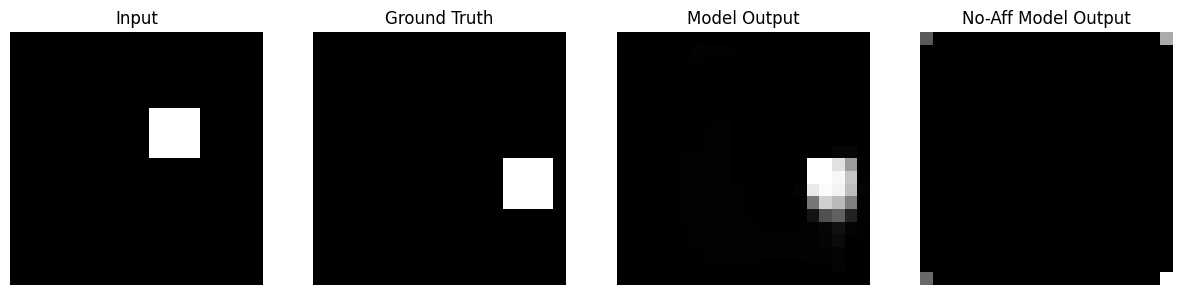

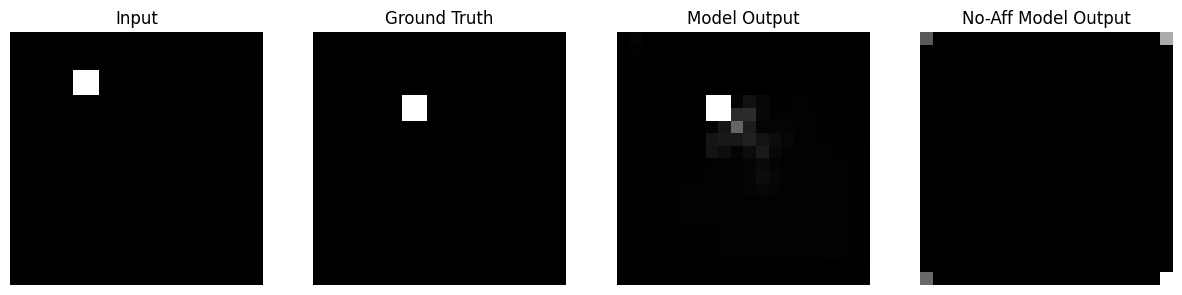

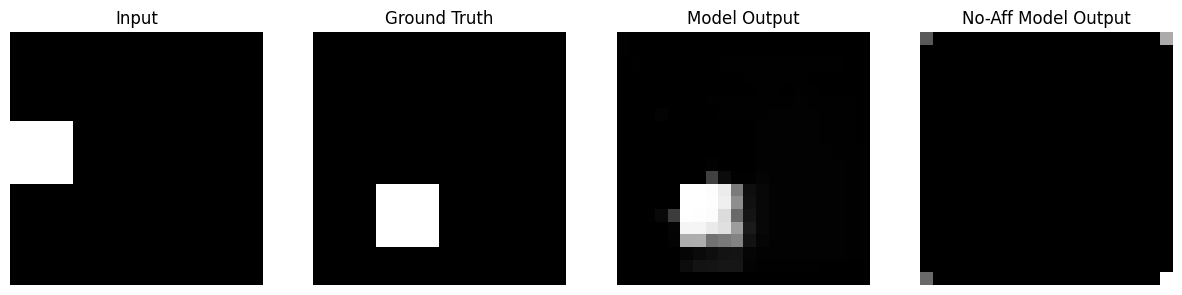

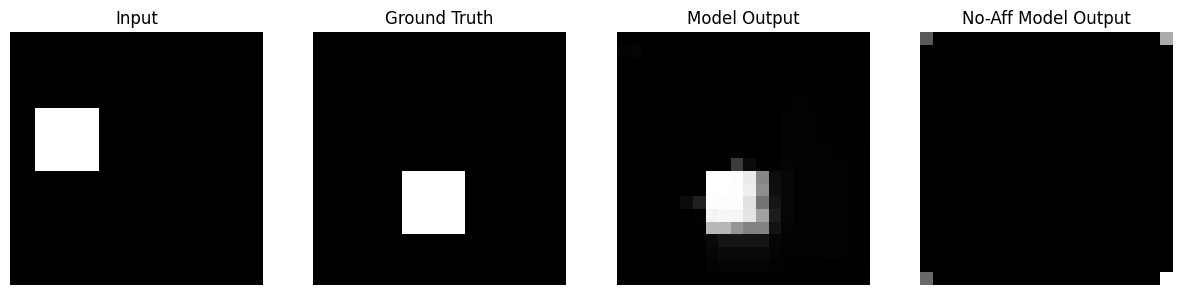

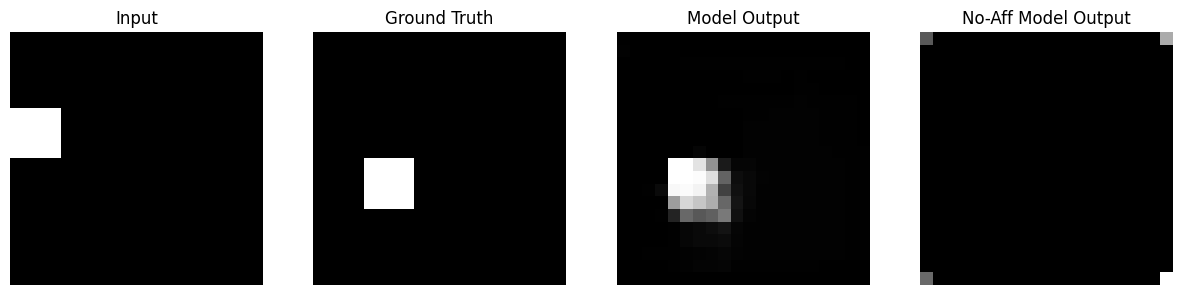

In [13]:
def show_images(images, titles):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        axs[i].imshow(images[i].squeeze().cpu(), cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

for i in range(len(test_dataset)):
    x_in, x_out = test_dataset[i]
    with torch.no_grad():
        model_output = model(x_in.unsqueeze(0).cuda()).squeeze(0)
        no_aff_output = no_aff_model(x_in.unsqueeze(0).cuda()).squeeze(0)

    show_images([x_in, x_out, model_output, no_aff_output], ['Input', 'Ground Truth', 'Model Output', 'No-Aff Model Output'])